# Кейс 1: классификация зловредного ПО

Владимир Клепов

In this notebook, we apply machine learning to a malware classification problem.

1. Perform exploratory data anlysis and cleanup
2. Establish a solid (~98% accuracy) baseline with logistic regression
3. Slighty improve logistic regression performance with a feature selection step
4. Boost the performance further using tree-based models: a raw decision tree and a random forest
5. Try tuning random forest hyperparameters with no gain
6. Speed up our random forest by using fewer estimators without compromising accuracy
7. And, finally, analyze the resulting model (over 99% accurate) and persist it for further use

In [1]:
!pip3 install pandas matplotlib scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

## 1. EDA

In [3]:
df = pd.read_csv('./TUANDROMD.csv')
df

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
all_rows = len(df)
df = df.dropna()
f'dropped {all_rows - len(df)} na rows'

'dropped 1 na rows'

,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute,Label
count,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,...,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000
mean,0.000896,0.000896,0.004928,0.083333,0.006944,0.087814,0.022849,0.023746,0.000224,0.596326,...,0.173163,0.245520,0.215950,0.091622,0.088710,0.056228,0.133065,0.013665,0.150090,0.798611
std,0.029924,0.029924,0.070037,0.276416,0.083053,0.283055,0.149440,0.152272,0.014967,0.490689,...,0.378431,0.430443,0.411526,0.288524,0.284356,0.230387,0.339682,0.116108,0.357199,0.401083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


distinct values: [0.0, 1.0]


<Axes: >

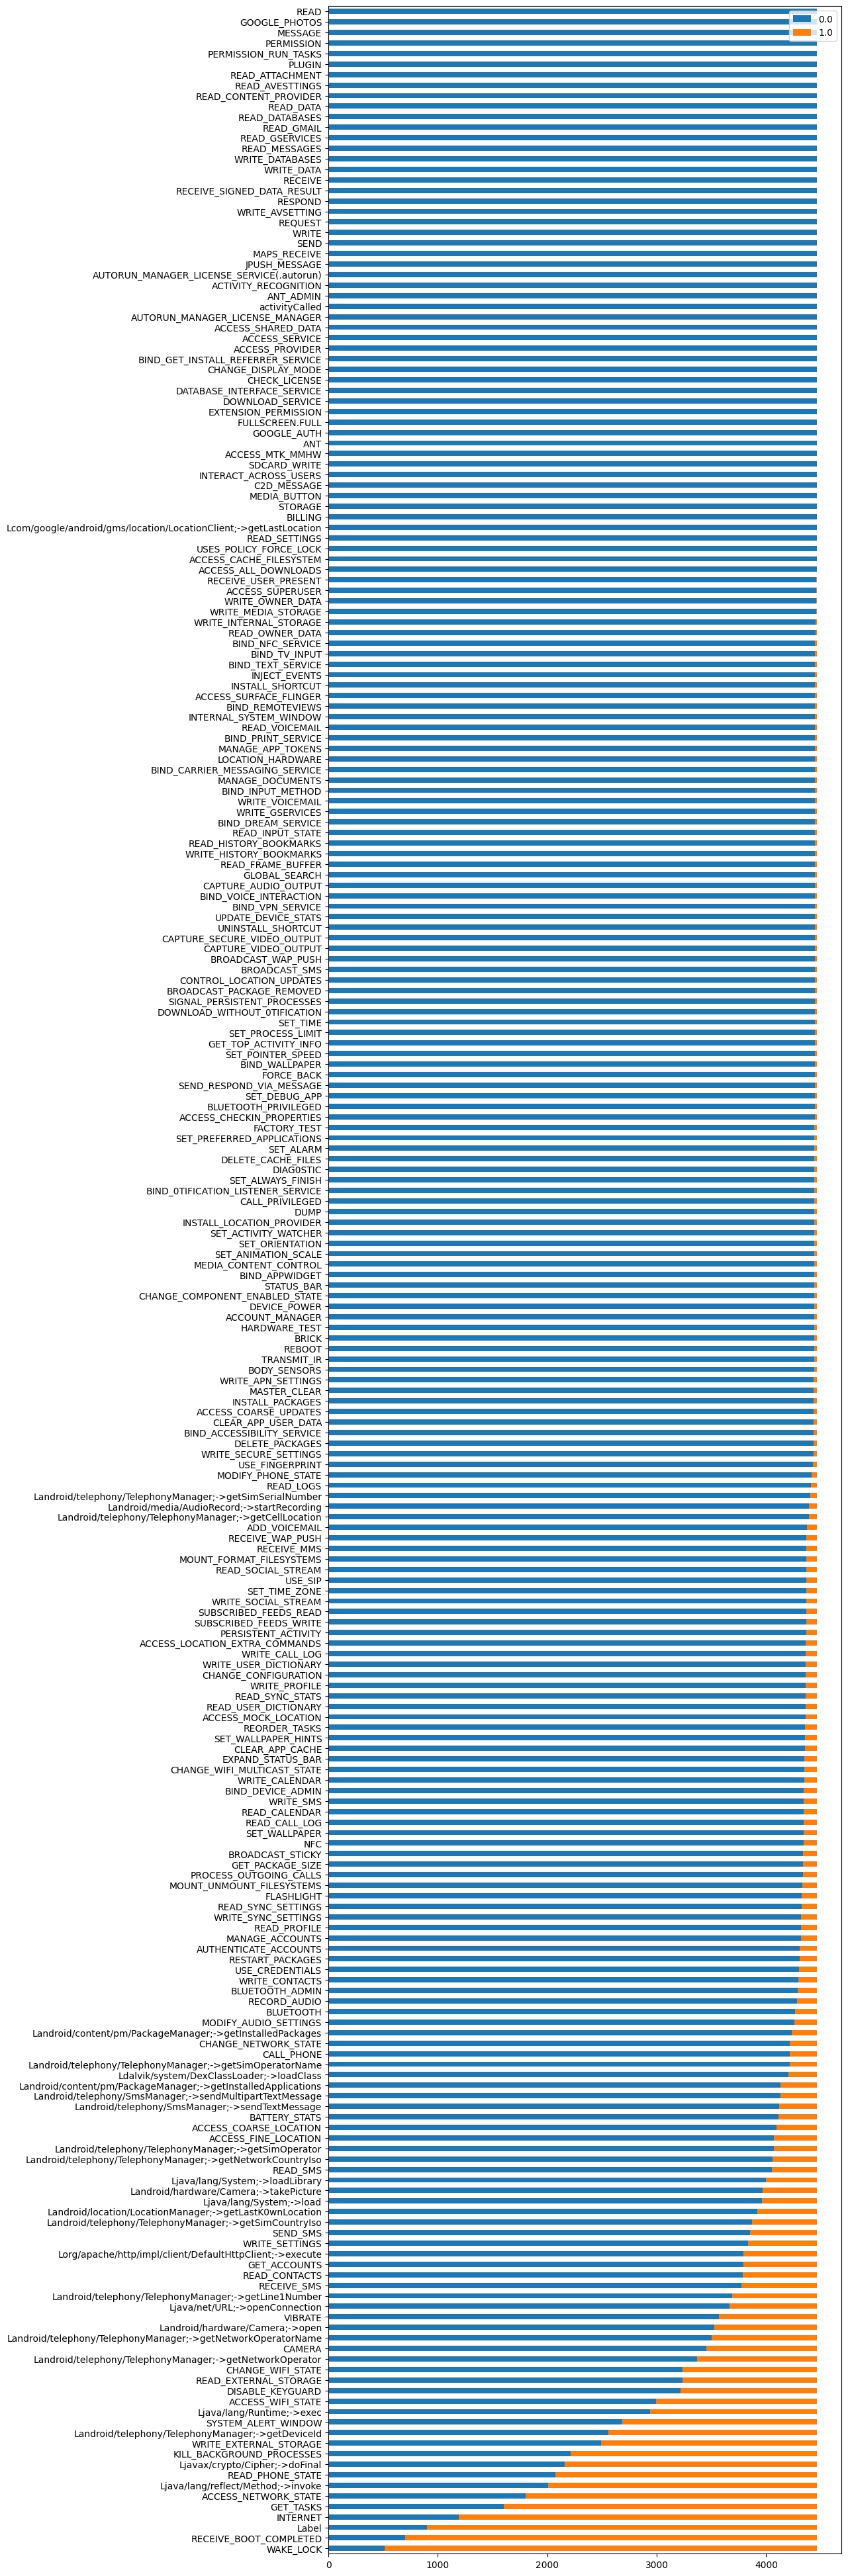

In [5]:
display(df.describe())
vc = {}
for col in df.columns:
    vc[col] = df[col].value_counts()
vc = pd.DataFrame(vc)
print(f'distinct values: {list(vc.index)}')
vc.transpose().sort_values(0.0).plot.barh(figsize=(10,50), stacked=True)

So:
- We have a table with 242 binary features
- Some features always have the same value, others are very rare
- I expect some multicollinearity, let's check it

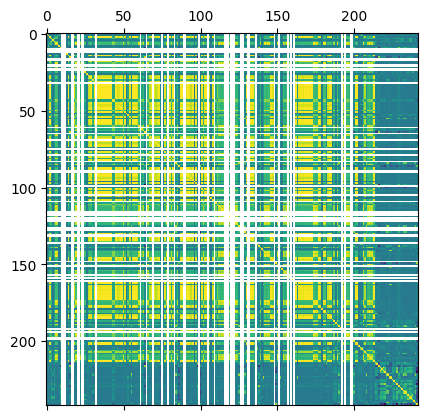

In [6]:
plt.matshow(df.corr())

In [7]:
# Prepare data for ML
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 2. Baseline: logistic regression

L2-regularized (the default)

In [8]:
lr_model = LogisticRegression().fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(f'accuracy score: {accuracy_score(y_test, y_pred)}')
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))

accuracy score: 0.9854423292273237


,0,1
0,161,5
1,8,719


Very decent score, can we do better?

## 2.1 Feature selection

I'd expect regularization to take care of low-variance and multicollinearity, but let's try it anyways

var 0.95: features left: 49 / 241


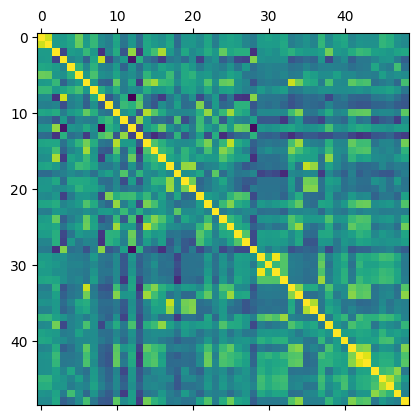

In [9]:
v_threshold = 0.95
sel = VarianceThreshold(threshold=(v_threshold * (1 - v_threshold)))
sel.fit_transform(X_train)
features = sel.get_feature_names_out()
print(f'var {v_threshold}: features left: {len(features)} / {len(X_train.columns)}')
X_fs_train = X_train[features]
X_fs_test = X_test[features]
plt.matshow(X_fs_train.corr())

We eliminated 80% features and the correlations look much better. How does it affect the model score?

In [10]:
lr_model = LogisticRegression(penalty='l2').fit(X_fs_train, y_train)
ys_pred = lr_model.predict(X_fs_test)
print(f'accuracy score: {accuracy_score(y_test, ys_pred)}')
display(pd.DataFrame(confusion_matrix(y_test, ys_pred)))

accuracy score: 0.9843225083986562


,0,1
0,160,6
1,8,719


Not bad, but not spectacular.

## 3. Decision Tree

For something different, let's apply a decision tree

In [11]:
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
ydt_pred = dt_model.predict(X_test)
print(f'accuracy score: {accuracy_score(y_test, ydt_pred)}')
display(pd.DataFrame(confusion_matrix(y_test, ydt_pred)))

accuracy score: 0.9944008958566629


,0,1
0,163,3
1,2,725


Promising, let's see if we can build upon this with a random forest

## 4. Random Forest

In [12]:
rf_model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
yrf_pred = rf_model.predict(X_test)
print(f'accuracy score: {accuracy_score(y_test, yrf_pred)}')
display(pd.DataFrame(confusion_matrix(y_test, yrf_pred)))

accuracy score: 0.9966405375139977


,0,1
0,165,1
1,2,725


Amazing, let's see if we can imporve with some hyperparameter tuning:

{'max_depth': 15}


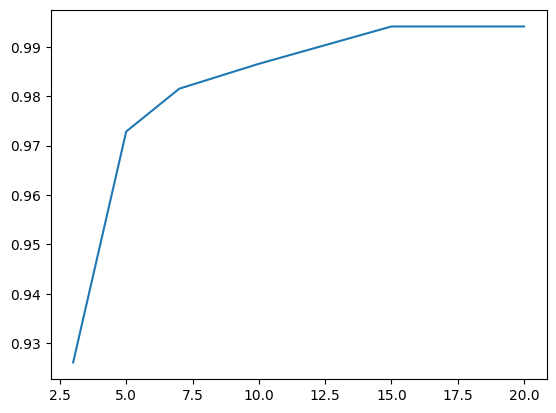

In [13]:
params = { 'max_depth': [3,5,7,9,10,15,20,None] }
hp_model = GridSearchCV(RandomForestClassifier(), params).fit(X_train, y_train)
print(hp_model.best_params_)
display(plt.plot(params['max_depth'], hp_model.cv_results_['mean_test_score']))

Nope, restricting max_depth does not help. Let's see how many estimators is enough to optimize model speed instead.

{'n_estimators': 51}


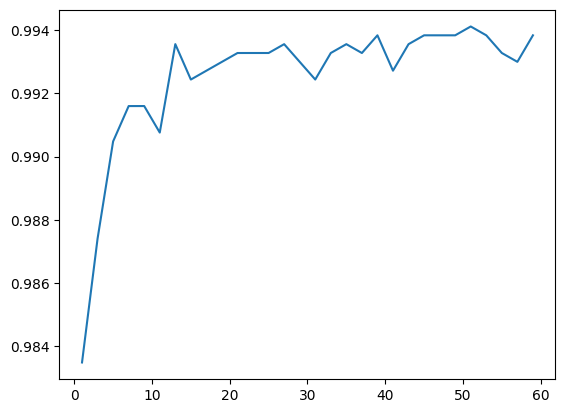

In [14]:
params = { 'n_estimators': range(1,60,2) }
hp_model = GridSearchCV(RandomForestClassifier(), params).fit(X_train, y_train)
print(hp_model.best_params_)
display(plt.plot(params['n_estimators'], hp_model.cv_results_['mean_test_score']))

The score does not improve significantly after ~20 estimators, so that's what we'll use for our final model

In [15]:
best_rf = RandomForestClassifier(n_estimators=20)
best_rf.fit(X_test, y_test)
print(best_rf.score(X_test, y_test))
display(pd.DataFrame(confusion_matrix(y_test, best_rf.predict(X_test))))

0.9977603583426652


,0,1
0,165,1
1,1,726


99%, remarkable result. 

Finally, let's look at the top features affecting our classification:

<Axes: ylabel='name'>

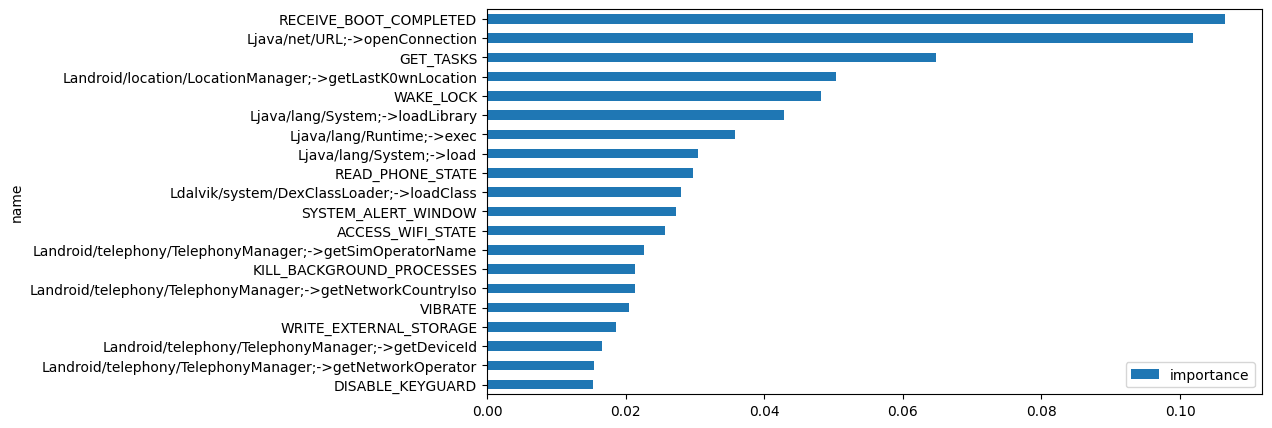

In [16]:
rf_features = pd.DataFrame({ 'name': X.columns, 'importance': best_rf.feature_importances_ })
rf_features.set_index('name').sort_values('importance')[-20:].plot.barh(figsize=(10,5))

And save out pre-trained model for later use:

In [17]:
dump(best_rf, 'malware_claffifier.joblib')

['malware_claffifier.joblib']